## Gradient Descent Extensions: Momentum and Adam

In this laboratory session, you will explore two popular extensions of basic Gradient Descent:

1. Momentum-based Gradient Descent  
2. Adam (Adaptive Moment Estimation)

We will test these methods on three classical benchmark functions in 2D space:

- **Sphere**: a simple, convex (wypukła), unimodal function that is relatively (stosunkowo) easy to optimize.
- **Rosenbrock**: features (charakteryzuje) a narrow valley, making convergence more difficult.
- **Rastrigin**: contains many local minima, making it challenging to escape suboptimal points.

By the end of this lab, you should understand how momentum and adaptive step-size techniques help accelerate gradient-based optimization, especially on surfaces (na powierzchni) with poor curvature (słaba krzywiznie) or local traps (pułapkami lokalnymi).

### Test Functions

You have been given implementations of the three test functions (Sphere, Rosenbrock, and Rastrigin) along with (wraz) their gradients, all inheriting from (dziedziczą ) the abstract `Problem` class.

In [183]:
import numpy as np
from abc import ABC, abstractmethod

class Problem(ABC):
    @abstractmethod
    def __call__(self, x: np.ndarray) -> float:
        """Compute the function value at point x."""
        raise NotImplementedError
    
    @abstractmethod
    def grad(self, x: np.ndarray) -> np.ndarray:
        """Compute the gradient at point x."""
        raise NotImplementedError

class Sphere(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(x**2)
    
    def grad(self, x: np.ndarray) -> np.ndarray:
        return 2 * x

class Rosenbrock(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)
    
    def grad(self, x: np.ndarray) -> np.ndarray:
        grad = np.zeros_like(x)
        n = x.size
        grad[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
        for i in range(1, n - 1):
            grad[i] = 200 * (x[i] - x[i-1]**2) - 400 * x[i] * (x[i+1] - x[i]**2) - 2 * (1 - x[i])
        grad[-1] = 200 * (x[-1] - x[-2]**2)
        return grad

class Rastrigin(Problem):
    def __call__(self, x: np.ndarray) -> float:
        A = 10
        n = x.size
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))
    
    def grad(self, x: np.ndarray) -> np.ndarray:
        A = 10
        return 2 * x + 2 * np.pi * A * np.sin(2 * np.pi * x)


### Visualization Tools

Here are some already implemented functions that you can use to produce visualizations:


In [184]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def prepare_mesh_grid(
    problem: Problem,
    bounds: tuple[float, float] = (-5.0, 5.0),
    grid_size: int = 50,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x_vals = np.linspace(bounds[0], bounds[1], grid_size)
    y_vals = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)

    Z = np.zeros_like(X)
    for i in range(grid_size):
        for j in range(grid_size):
            xy = np.array([X[i, j], Y[i, j]])
            Z[i, j] = problem(xy)

    return X, Y, Z, x_vals, y_vals


def plot_3d_surface(
    problem: Problem,
    grid_size: int = 50,
):
    X, Y, Z, _, _ = prepare_mesh_grid(problem=problem, grid_size=grid_size)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    ax.set_title(problem.__class__.__name__)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

def plot_contour_and_paths(
    problem: Problem,
    paths: list[np.ndarray],
    grid_size: int = 200,
    title: str = "",
):
    """
    Create an interactive contour plot of a 2D function and overlay multiple optimization paths.

    Args:
        problem: An instance of a Problem class.
        paths: List of numpy arrays; each array is of shape (epochs, 2) containing an optimization trajectory.
        title: Title for the plot.
    """
    _, _, Z, x_vals, y_vals = prepare_mesh_grid(problem, grid_size=grid_size)

    fig = go.Figure(
        data=go.Contour(
            x=x_vals,
            y=y_vals,
            z=Z,
            colorscale="Viridis",
            contours=dict(showlines=False),
            colorbar=dict(title="Function Value"),
        )
    )

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'pink', 'brown']
    
    for idx, path in enumerate(paths):
        color_idx = idx % len(colors)
        fig.add_trace(
            go.Scatter(
                x=path[:, 0],
                y=path[:, 1],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(width=2, color=colors[color_idx]),
                name=f"Run {idx+1}",
                showlegend=True,
            )
        )

    fig.update_layout(
        title=title, xaxis_title="x", yaxis_title="y", width=800, height=700,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show()

### 1. Getting familiar with (zapoznanie się z) optimization test problems (testowymi)

Understand the landscapes (charakterystyki) of the test functions to predict optimization challenges (wyzwania). Visualize each function. Use `plot_3d_surface` to generate a 3D surface plot for each function (Sphere, Rosenbrock, Rastrigin). Use `plot_contour_and_paths` with an empty paths list to generate a 2D contour plot for each function.

Which function appears easiest to optimize? Hardest? Why?

Answer: I think the easiest function to optimize is Sphere function, because it is is convex, so basic stochastic gradient decent should be able to find a optimum. The hardest function to optimize is the Rastrigin function, because it is not convect and has many  suboptimal points. Basic stochastic gradient descent will probably get stuck quickly in a local optimum.
To optimize Rastrigin function, it’s better to use a heuristic method, like simulated annealing or an evolutionary method.

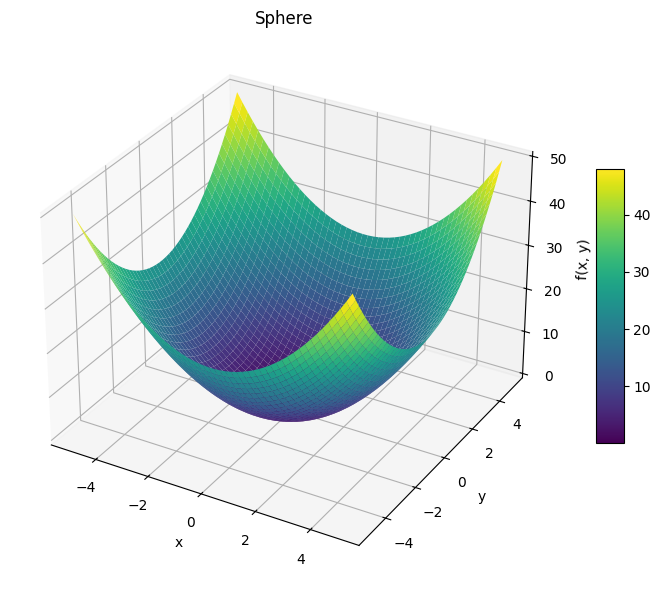

In [185]:
sphere = Sphere()

plot_3d_surface(problem=sphere)

plot_contour_and_paths(problem=sphere, paths=[], title="Sphere Function")

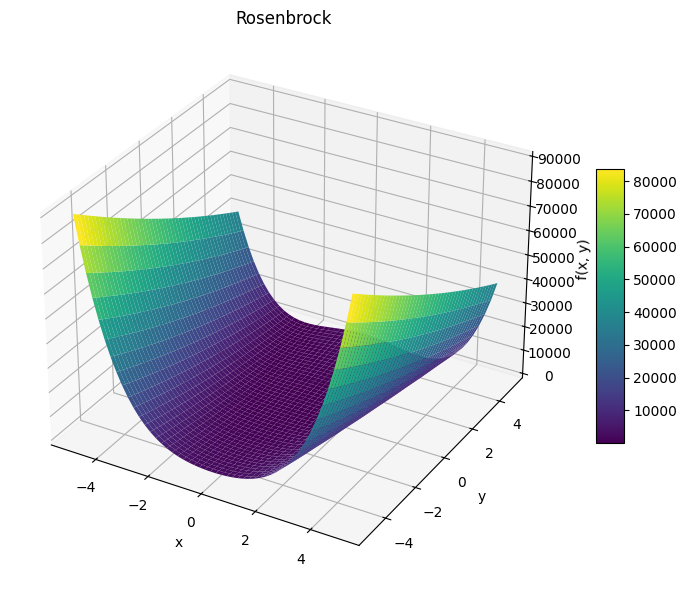

In [186]:
rosen = Rosenbrock()

plot_3d_surface(problem=rosen)

plot_contour_and_paths(problem=rosen, paths=[], title="Sphere Function")

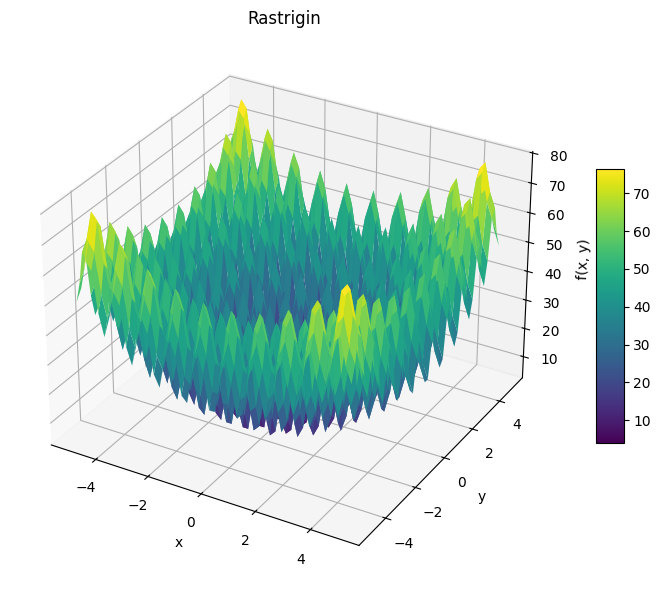

In [187]:
rastr = Rastrigin()


plot_3d_surface(problem=rastr)

# Wykres konturowy (bez ścieżek)
plot_contour_and_paths(problem=rastr, paths=[], title="Sphere Function")



### 2. Momentum method

Your task is to implement the Momentum optimizer with the interface:


In [203]:
def momentum(
    problem: Problem,
    initial_solution: np.ndarray,
    alpha: float,
    beta: float,
    number_of_epochs: int,
): 
    w = initial_solution.copy()
    v = np.zeros_like(w)
    w_tab = [w.copy()]
    f_tab = [problem(w)]
    v_norms = [np.linalg.norm(v)] 

    for _ in range(number_of_epochs):
        grad = problem.grad(w)
        v = beta * v + alpha * grad
        w = w - v

        w_tab.append(w.copy())
        f_tab.append(problem(w))
        v_norms.append(np.linalg.norm(v))

    return np.array(w_tab), f_tab, v_norms

Where:

- `initial_solution` is your starting point.
- `alpha` is the learning rate.
- `beta` is the momentum parameter (commonly 0.9).

### 3. Experiments with Momentum

Observe how Momentum performs (działa) on different functions. Use following parameters:

- `initial_solution = np.array([2.0, 2.0])`
- `alpha = 0.01`
- `beta = 0.9`
- `number_of_epochs = 100`

For each function, plot:

- Function value vs. epoch.
- For Rosenbrock and Rastrigin functions, experiment with decreasing (obniżaniem) the learning rate `alpha` (try values like 0.001 and 0.0001) to observe how it affects convergence.
- Velocity norm (e.g. `np.linalg.norm`) vs. epoch.

How does the velocity norm evolve (ewoluuje) ? Does it correlate with convergence speed?


Answer: In the case of the Sphere function, the velocity norm decreases as the number of epochs increases, which is expected behavior. However, unusual behavior was observed when applying momentum to the Rosenbrock function. In that case, the velocity norm experienced an overflow, resulting in invalid values. As a result, the algorithm did not converge properly. In the case of the Rastrigin function, the algorithm got stuck in a local minimum and oscillated around it.

Momentum has a direct impact on the function value, as it determines how large the update steps are in the direction of the minimum. Therefore, momentum is indeed correlated with convergence speed – it accelerates convergence when tuned appropriately. When the velocity norm is small, it probably means that the algorithm is close to convergence. This means that the function is flattening out.

In [189]:

def momentum_experiment(problem, initial_solution, alpha, beta, epochs):
    
    _, f_values, v_norms = momentum(problem, initial_solution, alpha, beta, epochs)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(f_values)
    plt.title("Function Value vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("f(w)")

    plt.subplot(1, 2, 2)
    plt.plot(v_norms)
    plt.title("Velocity Norm vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("||v||")

    plt.tight_layout()
    plt.show()

**Sphere - momentum**

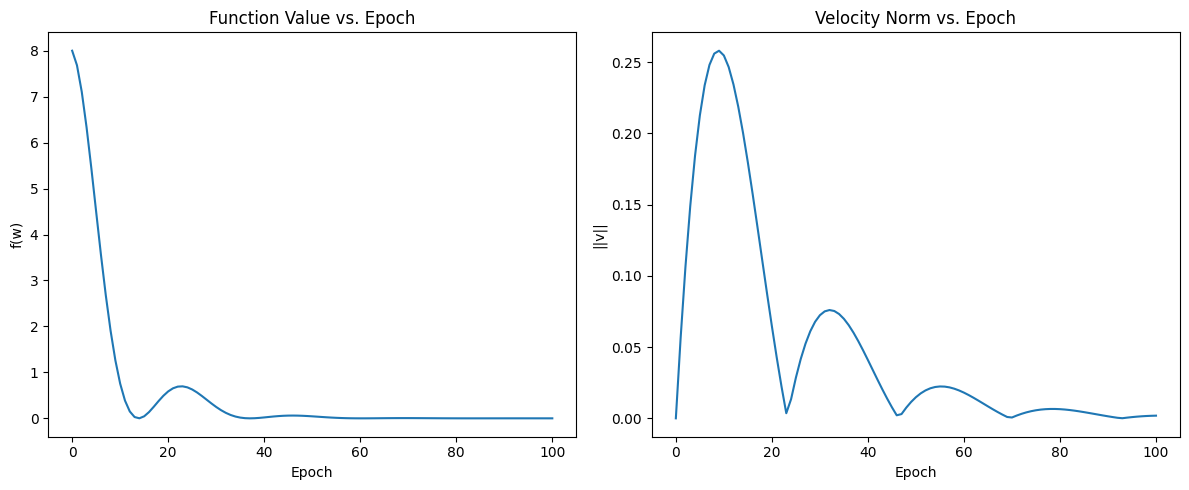

In [190]:
initial_solution = np.array([2.0, 2.0])
alpha = 0.01
beta = 0.9
number_of_epochs = 100


momentum_experiment(Sphere(), initial_solution, alpha, beta, number_of_epochs)


**Rosenbrock - momentum**

C:\Users\jacek\AppData\Local\Temp\ipykernel_38216\430869439.py:24: RuntimeWarning:

overflow encountered in square

C:\Users\jacek\AppData\Local\Temp\ipykernel_38216\430869439.py:29: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\jacek\AppData\Local\Temp\ipykernel_38216\4107793154.py:16: RuntimeWarning:

invalid value encountered in add



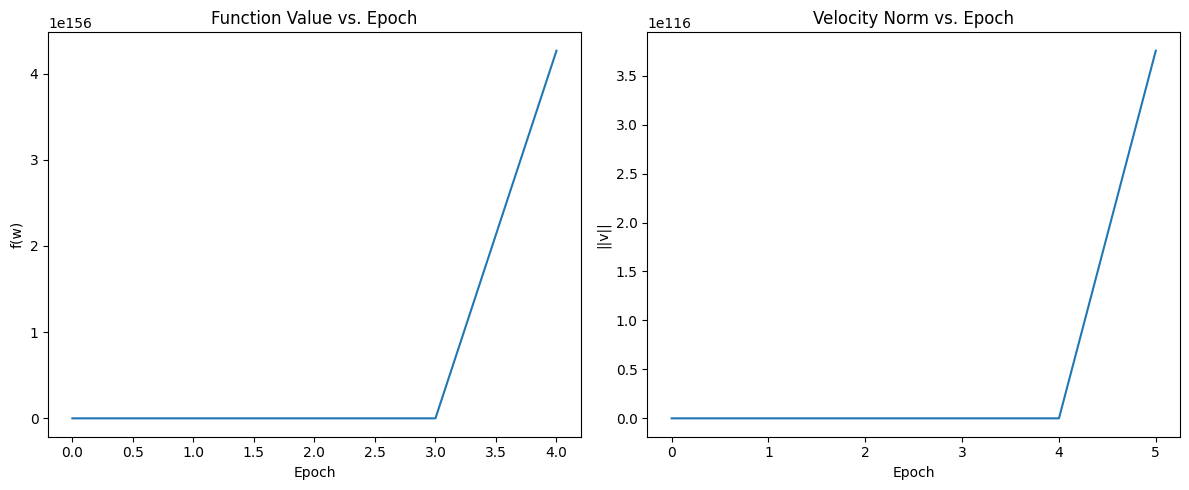

In [191]:
momentum_experiment(Rosenbrock(), initial_solution, alpha, beta, number_of_epochs)


**Rastring - momentum**

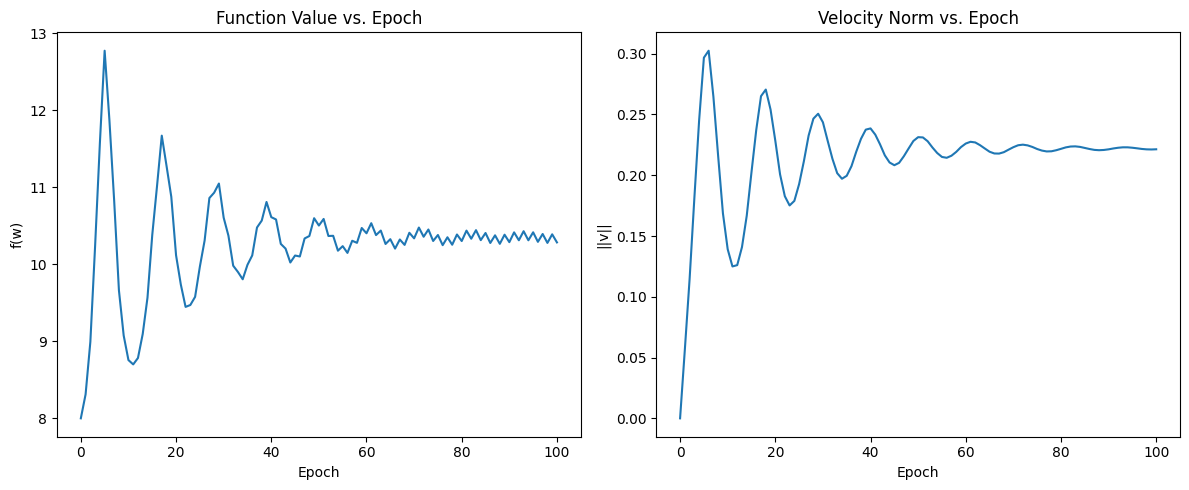

In [192]:
momentum_experiment(Rastrigin(), initial_solution, alpha, beta, number_of_epochs)

In [198]:
print(initial_solution)

[2. 2.]


**Experiment with decreasing the learning rate `alpha` (try values like 0.001 and 0.0001) for Rosenbrock and Rastrigin functions**

In [194]:
def momentum_experiment(problem, initial_solution, alpha, beta, epochs):
    
    _, f_values, v_norms = momentum(problem, initial_solution, alpha, beta, epochs)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(f_values)
    plt.yscale("log")
    plt.title("Function Value vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("f(w)")

    plt.subplot(1, 2, 2)
    plt.plot(v_norms)
    plt.title("Velocity Norm vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("||v||")

    plt.tight_layout()
    plt.show()
    print(f_values[-1])

Rastrigin - momentum experiment and alpha 0.001


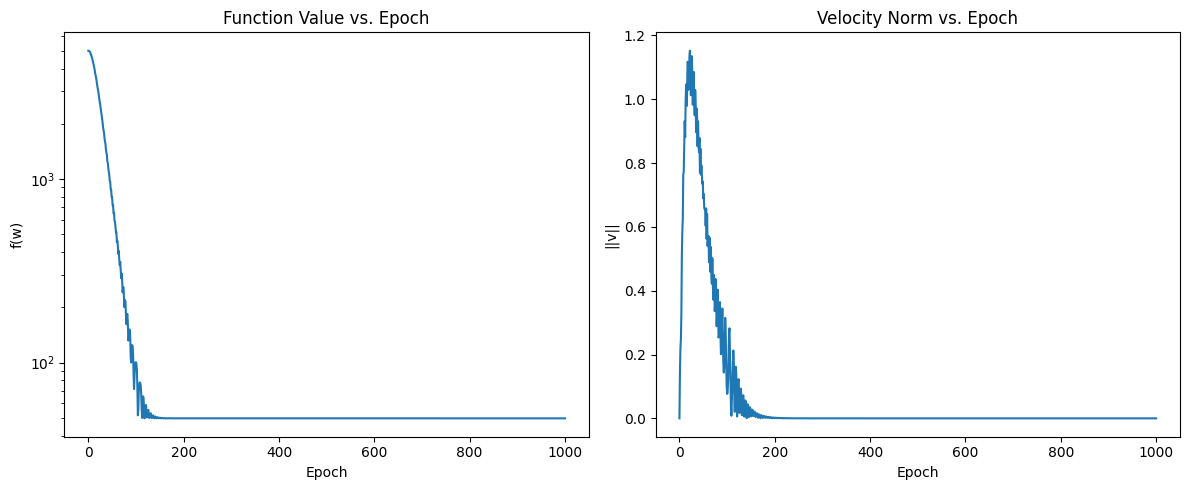

49.74744586908446
Rastrigin - momentum experiment and alpha 0.0001


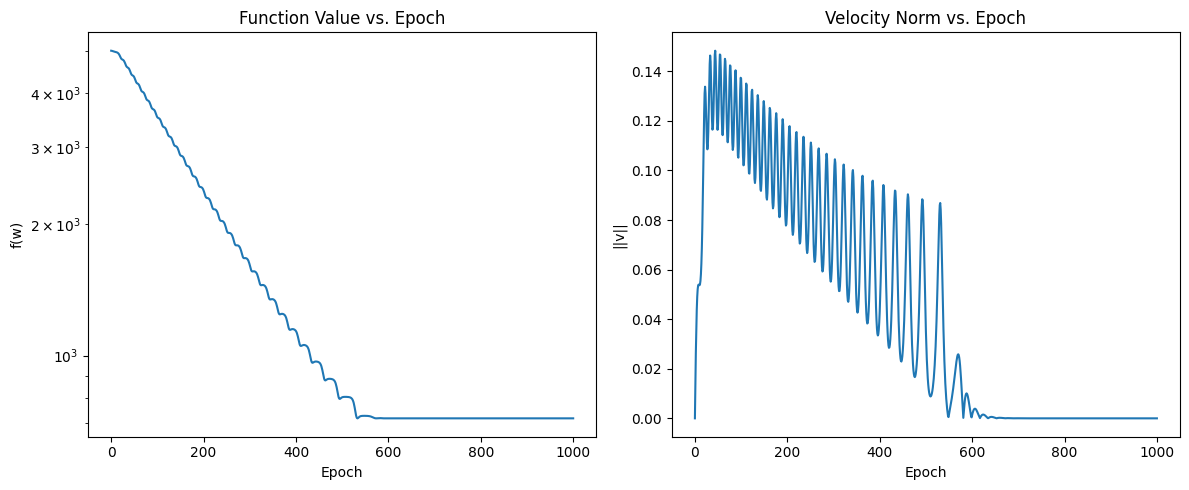

718.2373041281138
Rastrigin - momentum experiment and alpha 0.1


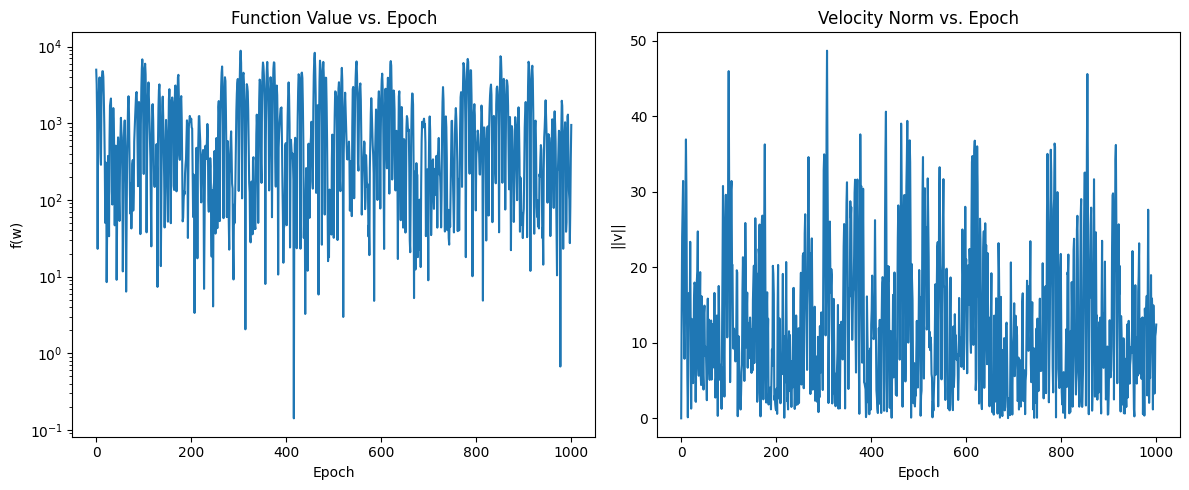

951.0254891587732
Rosenbrock - momentum experiment and alpha 0.001


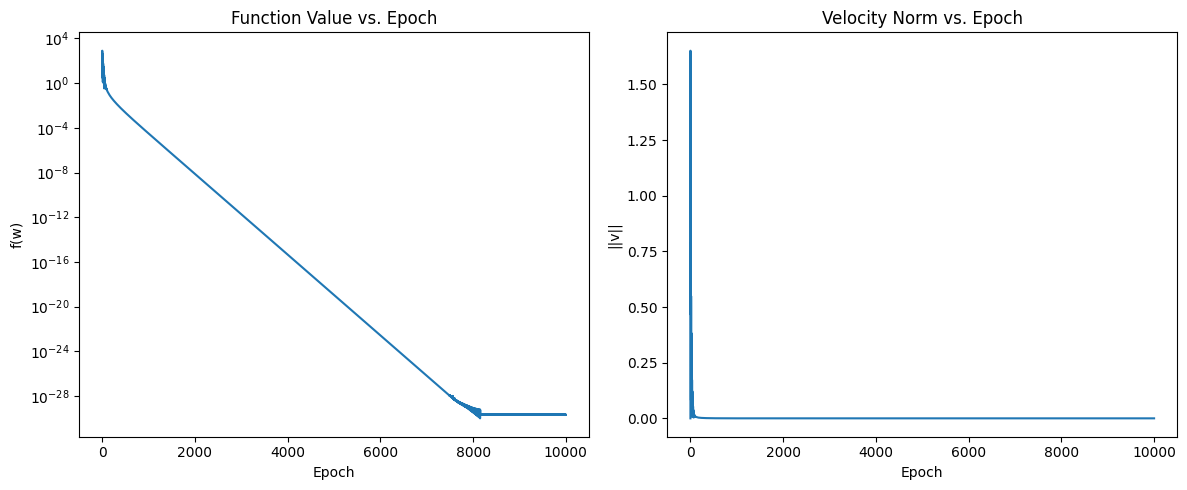

2.0214560696288428e-30
Rosenbrock - momentum experiment and alpha 0.0001


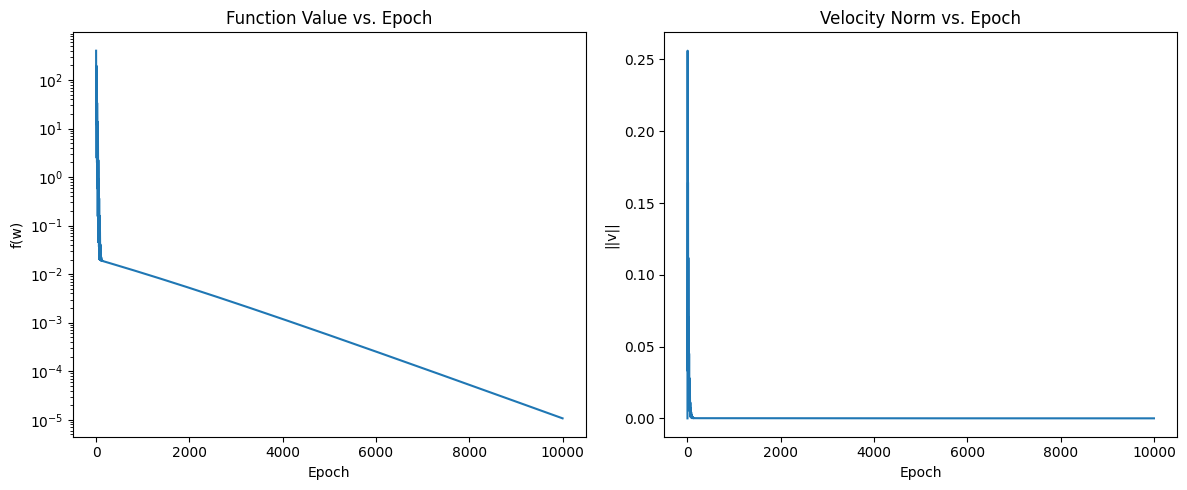

1.0701011615201383e-05


In [195]:
initial_solution = np.array([50.0, 50.0])
for alpha in [0.001, 0.0001, 0.1]:
    print("Rastrigin - momentum experiment and alpha {}".format(alpha) ) 
    momentum_experiment(Rastrigin(), initial_solution, alpha, beta, 1000)

print("================================================================")
initial_solution = np.array([2, 2])
for alpha in [0.001, 0.0001]:
    print("Rosenbrock - momentum experiment and alpha {}".format(alpha) ) 
    momentum_experiment(Rosenbrock(), initial_solution, alpha, beta, 10000)

When I experimented with different values of alpha to minimize the Rastrigin function, I discovered that the best result was achieved with alpha = 0.001. However, it still did not reach the global minimum. No matter what alpha you choose, the algorithm tends to get stuck in a local minimum.
In the case of the Rosenbrock function, if you don’t choose a good initial value – for example, [2, 2] – and a low learning rate like 0.001 or 0.0001, the algorithm may converge to a global minimum. But if you choose a poor initial value, even a small learning rate won’t help. This function is very sensitive to the initial conditions and the alpha hyperparameter. It is worth noting that a large alpha can speed up convergence, but it may cause the algorithm to skip over the global minimum. On the other hand, if you choose a small alpha, the algorithm may get stuck in a local minimum.


### 4. Momentum Hyperparameters

Fix `alpha = 1e-4`, `initial_solution = np.array([2.0, 2.0])`, `number_of_epochs = 100`.  
Use $\beta \in \{0.5, 0.75, 0.9, 0.95, 0.99\}$ on the Rosenbrock function.  
How does increasing $\beta$ affect convergence? Stability?


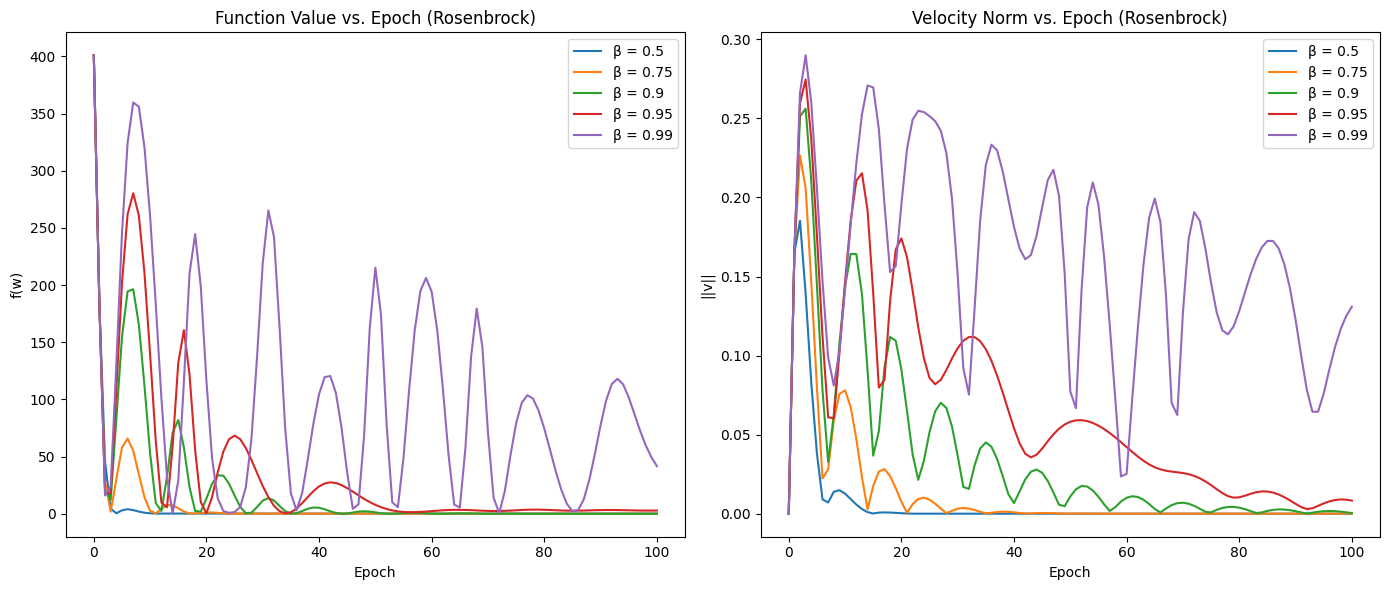

In [196]:
beta_values = [0.5, 0.75, 0.9, 0.95, 0.99]
alpha = 1e-4
initial_solution = np.array([2.0, 2.0])
number_of_epochs = 100


results = {}

for beta in beta_values:
    w_tab, f_tab, v_norms = momentum(
        problem=Rosenbrock(),
        initial_solution=initial_solution,
        alpha=alpha,
        beta=beta,
        number_of_epochs=number_of_epochs
    )
    results[beta] = (f_tab, v_norms)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for beta in beta_values:
    plt.plot(results[beta][0], label=f"β = {beta}")
plt.title("Function Value vs. Epoch (Rosenbrock)")
plt.xlabel("Epoch")
plt.ylabel("f(w)")
plt.legend()


plt.subplot(1, 2, 2)
for beta in beta_values:
    plt.plot(results[beta][1], label=f"β = {beta}")
plt.title("Velocity Norm vs. Epoch (Rosenbrock)")
plt.xlabel("Epoch")
plt.ylabel("||v||")
plt.legend()

plt.tight_layout()
plt.show()

Increasing beta can negatively affect convergence because it slows down the reduction of oscillations. However, if we use a smaller beta, like 0.5 or 0.75, the oscillations are reduced more quickly, and the algorithm converges faster.

In the case of the Rosenbrock function, we should start near the basin of the global minimum, which is easier to observe on 3D plots.



### 5. Adam

Implement the Adam optimizer:

def adam(
    problem: Problem,
    initial_solution: np.ndarray,
    alpha: float,
    beta1: float,
    beta2: float,
    number_of_epochs: int,
    epsilon: float = 1e-8
): 
    ...

Where:

- `beta1` is the exponential decay rate (wykładniczy współczynnik zaniku) for first moment estimates (similar to momentum).
- `beta2` is the exponential decay rate (wykładniczy współczynnik zaniku) for second moment estimates (variance).



In [220]:
def adam(problem, initial_solution: np.ndarray, alpha: float, beta1: float, beta2: float,
         number_of_epochs: int, epsilon: float = 1e-8):
    
    w = initial_solution.copy()
    m = np.zeros_like(w)  
    v = np.zeros_like(w) 
    
    w_tab = [w.copy()]
    f_tab = [problem(w)]
    v_norms = []
    print("Epochs:", number_of_epochs)

    for t in range(1, int(number_of_epochs) + 1):
        grad = problem.grad(w)

        m = beta1 * m + (1 - beta1) * grad
        
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        w = w - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        w_tab.append(w.copy())
        f_tab.append(problem(w))
        v_norms.append(np.linalg.norm(m))  

    return np.array(w_tab), f_tab, v_norms

### 6. Comparing Adam with Momentum

Run both optimizers on Sphere, Rosenbrock and Rastrigin. Use:

- `initial_solution = np.array([2.0, 2.0]), number_of_epochs = 100`
- **Momentum**: `alpha = 0.01`, `beta = 0.9`
- **Adam**: `alpha = 0.01`, `beta1 = 0.9`, `beta2 = 0.999`, `epsilon = 1e-8`

Visualize optimization paths. Use `plot_contour_and_paths` to overlay paths from both methods.  
Plot function value vs. epoch for both methods.

**Sphere**

Epochs: 100


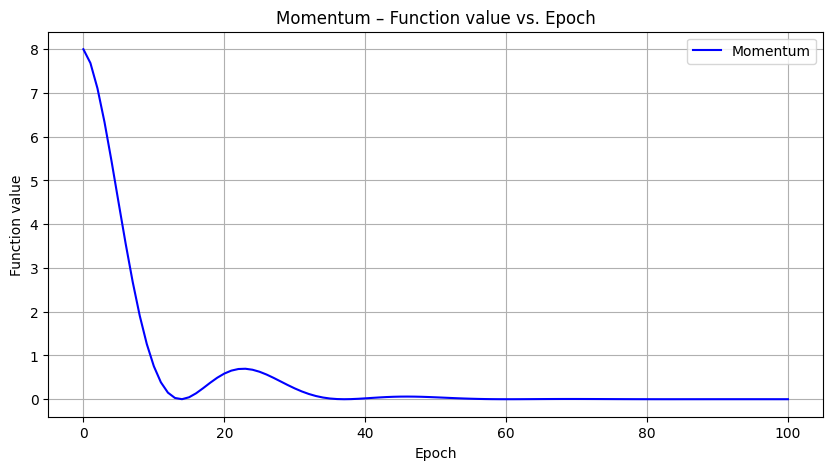

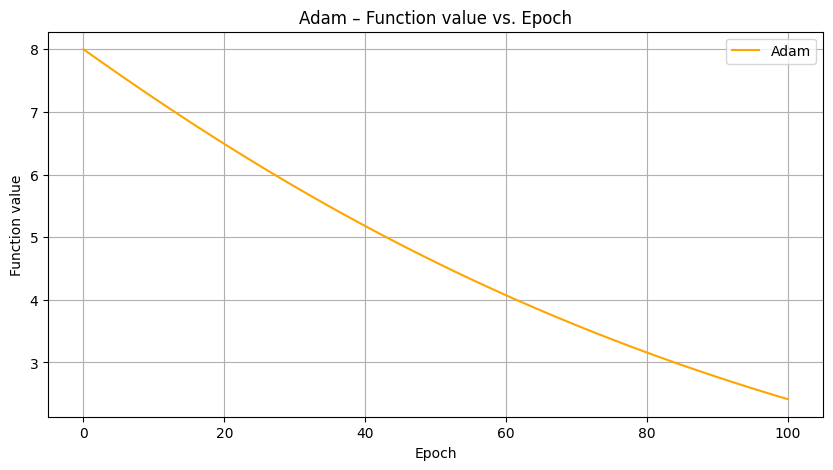

In [237]:

initial_solution = np.array([2.0, 2.0])
number_of_epochs = 100
alpha = 0.01

beta = 0.9

beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8



problem =  Sphere()


w_momentum, f_momentum, _ = momentum(problem, initial_solution, alpha, beta, number_of_epochs)

w_adam, f_adam, _ = adam(problem, initial_solution, alpha, beta1, beta2, number_of_epochs, epsilon)


plot_contour_and_paths(problem, [w_momentum, w_adam])


plt.figure(figsize=(10, 5))
plt.plot(f_momentum, label="Momentum", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Function value")
plt.title("Momentum – Function value vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f_adam, label="Adam", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Function value")
plt.title("Adam – Function value vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

For convex function momentum is faster algorithm.

**Rastrigin**

Epochs: 100


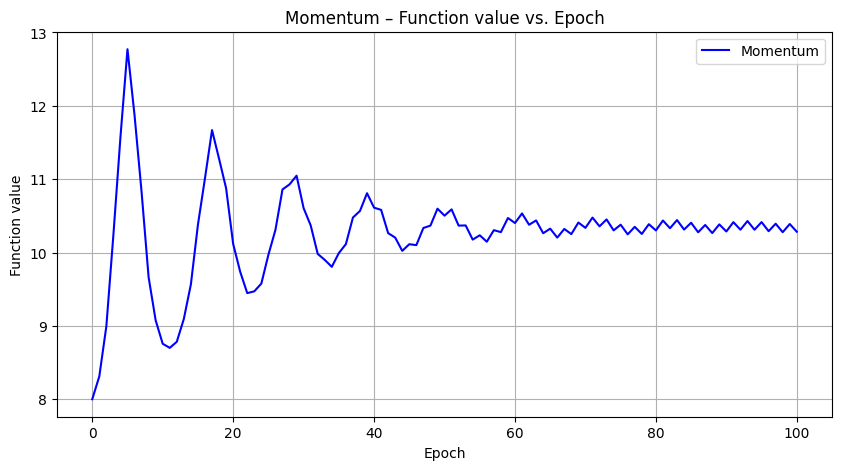

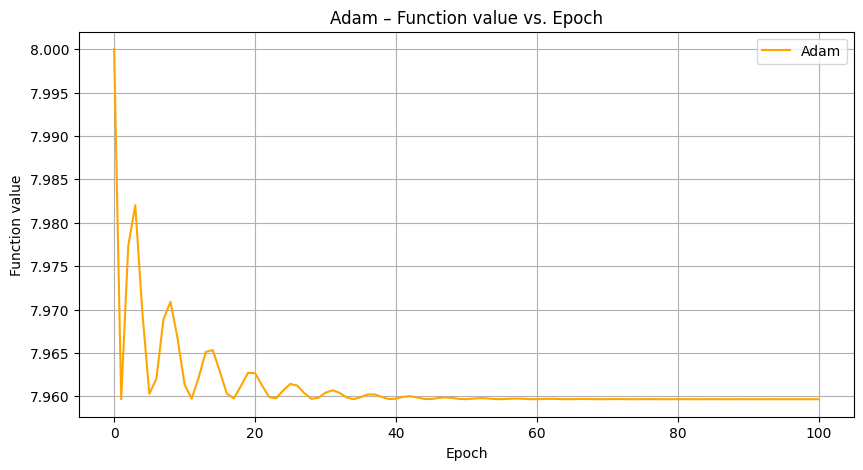

In [236]:
problem =  Rastrigin()


w_momentum, f_momentum, _ = momentum(problem, initial_solution, alpha, beta, number_of_epochs)

w_adam, f_adam, _ = adam(problem, initial_solution, alpha, beta1, beta2, number_of_epochs, epsilon)


plot_contour_and_paths(problem, [w_momentum, w_adam])


plt.figure(figsize=(10, 5))
plt.plot(f_momentum, label="Momentum", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Function value")
plt.title("Momentum – Function value vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f_adam, label="Adam", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Function value")
plt.title("Adam – Function value vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

**Rosenbrock**

Epochs: 100


C:\Users\jacek\AppData\Local\Temp\ipykernel_38216\430869439.py:24: RuntimeWarning:

overflow encountered in square

C:\Users\jacek\AppData\Local\Temp\ipykernel_38216\430869439.py:29: RuntimeWarning:

overflow encountered in scalar multiply

C:\Users\jacek\AppData\Local\Temp\ipykernel_38216\120879812.py:16: RuntimeWarning:

invalid value encountered in add



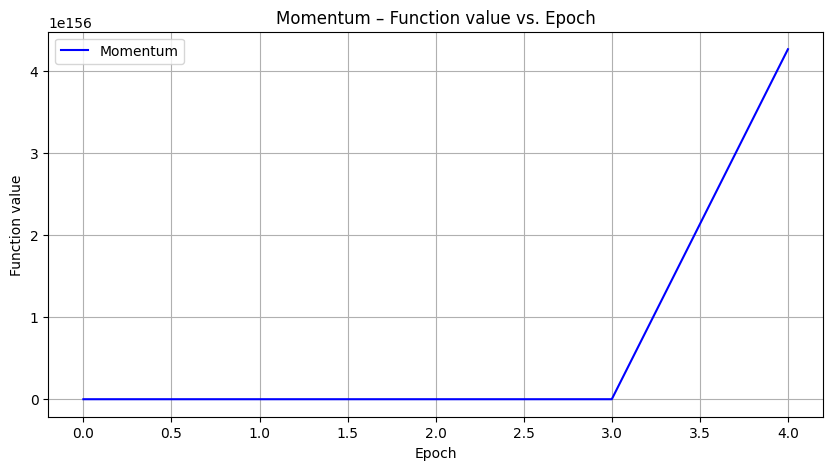

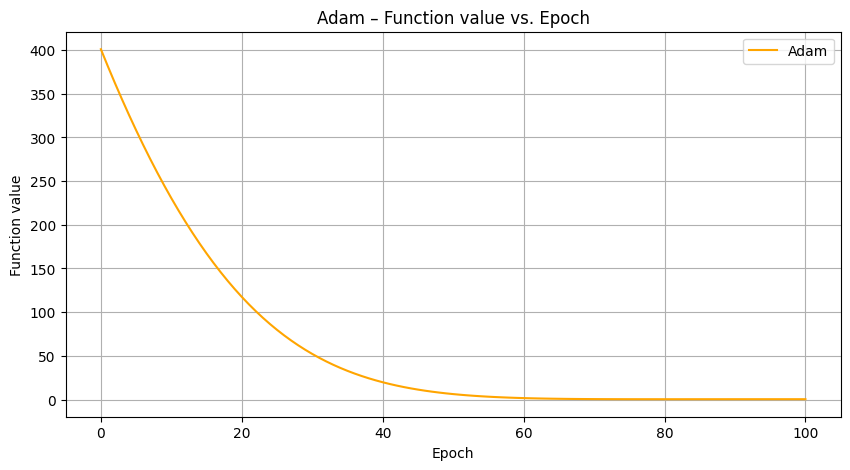

In [235]:
alpha=0.01
problem =  Rosenbrock()


w_momentum, f_momentum, _ = momentum(problem, initial_solution, alpha, beta, number_of_epochs)

w_adam, f_adam, _ = adam(problem, initial_solution, alpha, beta1, beta2, number_of_epochs, epsilon)


#plot_contour_and_paths(problem, [w_momentum, w_adam])


plt.figure(figsize=(10, 5))
plt.plot(f_momentum, label="Momentum", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Function value")
plt.title("Momentum – Function value vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(f_adam, label="Adam", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Function value")
plt.title("Adam – Function value vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

If we set alpha = 0.01 in the Momentum algorithm, it causes an overflow. However, for Adam, it remains stable and quickly finds the minimum. In general, Adam is a better algorithm for functions that are not convex.
